In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

dirs = ['../DataGeneration/Python', './net/']
for d in dirs:
    if d not in sys.path:
        sys.path.append(d)

import Sample
import Dataloader

from Transformer import Transformer

In [2]:
## Boilerplate setup code

TRAIN_DATASET_PATH = '../Dataset/CC10k.npy'
VAL_DATASET_PATH = '../Dataset/CCVal300.npy'
N_WORKERS = 0

# From data
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
BATCH_SIZE = 1

# Load some of our data
data_train = Dataloader.formattedLoader(d_output, TRAIN_DATASET_PATH) # Get input data formatted for network
data_val = Dataloader.formattedLoader(d_output, VAL_DATASET_PATH) # Get input data formatted for network

dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

In [51]:
def load_model(model_path):
    state_dict = torch.load(model_path)
    optimizePrime = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
    optimizePrime.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(optimizePrime.parameters(), lr=LR)
    return optimizePrime


def show_samples(model):
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

    dl = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

    for x, y in dl:
        break

    for i, ax in enumerate(axs.flat):
        X = model(x.float())[i]
        X = X.detach().numpy()
        ax.plot(range(len(y[i])), y[i])
        
        ax.plot(range(len(X)), X)
        ax.legend(["Target", "Prediction"])
        ax.set_title(f"Plot {i+1}")
        
    plt.tight_layout()
    plt.show()

In [4]:
def fit(model, optimizer, loss_function, EPOCHS, model_save_path, perturb=False, noise_scale=.1):
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_loss_best = np.inf 


    for epoch in range(EPOCHS):
        with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCHS}]") as pbar:
            
            # Training phase
            model.train()
            running_loss = 0

            for i, (x, y) in enumerate(dataloader_train):
                
                if perturb:
                    # Add random noise to the input tensor
                    noise_tensor = torch.randn_like(x) * noise_scale  # 0.1 is the noise scale
                    perturbed_input = x + noise_tensor                

                # Forward pass
                optimizer.zero_grad()
                x = x.float()
                yhat = model(x)
                loss = loss_function(y.float(), yhat)

                # Back pass
                loss.backward()
                optimizer.step()

                running_loss+= loss.item()
                pbar.set_postfix({'total loss': running_loss})
                pbar.update(x.shape[0])

            performance = running_loss / len(dataloader_train.dataset)
            epoch_train_loss.append(performance)
            print(f"Epoch {epoch} train_loss: {performance}")

            # Validation phase
            model.eval()
            running_loss = 0

            with torch.no_grad():
                for i, (x, y) in enumerate(dataloader_val):
                    
                    # Forward pass
                    x = x.float()
                    yhat = model(x)
                    loss = loss_function(y.float(), yhat)
                    running_loss+= loss.item()

                # Loss per sample
                performance = running_loss / len(dataloader_val.dataset)
                epoch_val_loss.append(performance)
                print(f"Epoch {epoch} val_loss: {performance}")

        if epoch_val_loss[-1] < epoch_loss_best:
            epoch_loss_best = performance
            torch.save(model.state_dict(), model_save_path)
    return epoch_train_loss, epoch_val_loss    


# Model 6 (Custom Loss Function) 

In [65]:
## Model 6 Architecture ##

d_input = 5 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10


# Model hyperparameters
BATCH_SIZE = 50
D_MODEL = 32 # Best: 24
q = 6 
v = 6
h = 6
Ne =4
Nd = 4
DROPOUT = 0.3 # Best: 3


model6 = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, DROPOUT, noise_scale=0.35) 
model6.init_weights()
model_save_path = f'Checkpoints/model6_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'


dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

varMSE = nn.MSELoss()
mse = nn.MSELoss()

#### Custom Loss Function ####
def var_loss(outputs, targets): 
    return varMSE(torch.var(outputs, dim=0), torch.var(targets, dim=0))

def criterion(outputs, targets):
    return var_loss(outputs, targets) + mse(outputs, targets)



[Epoch   1/6]: 100%|██████████| 10000/10000 [00:18<00:00, 540.12it/s, total loss=2.47e+5]


Epoch 0 train_loss: 24.737998516845703
Epoch 0 val_loss: 9.30969757080078


[Epoch   2/6]: 100%|██████████| 10000/10000 [00:19<00:00, 503.61it/s, total loss=9.01e+4]


Epoch 1 train_loss: 9.008784652709961
Epoch 1 val_loss: 7.511082255045573


[Epoch   3/6]: 100%|██████████| 10000/10000 [00:17<00:00, 567.64it/s, total loss=7.33e+4]


Epoch 2 train_loss: 7.331963493347168
Epoch 2 val_loss: 5.952995096842448


[Epoch   4/6]: 100%|██████████| 10000/10000 [00:19<00:00, 516.28it/s, total loss=5.69e+4]


Epoch 3 train_loss: 5.687015156555176
Epoch 3 val_loss: 4.634724426269531


[Epoch   5/6]: 100%|██████████| 10000/10000 [00:17<00:00, 558.07it/s, total loss=4.64e+4]


Epoch 4 train_loss: 4.644211325073242
Epoch 4 val_loss: 4.492648010253906


[Epoch   6/6]: 100%|██████████| 10000/10000 [00:18<00:00, 555.16it/s, total loss=4.13e+4]


Epoch 5 train_loss: 4.133007287597656
Epoch 5 val_loss: 4.251924031575521


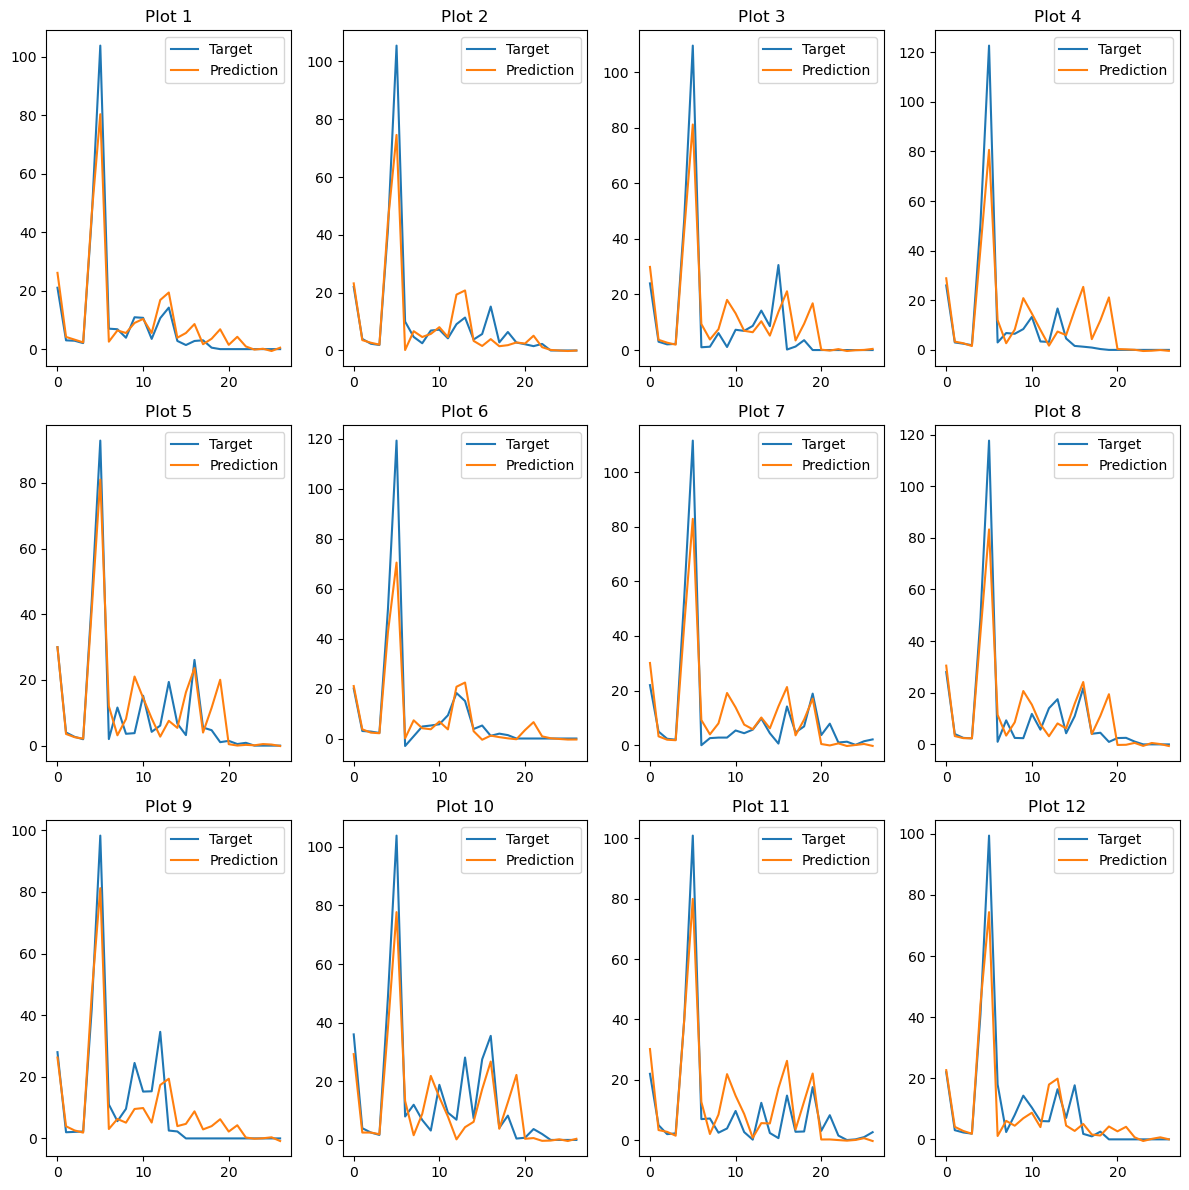

[Epoch   1/1]: 100%|██████████| 10000/10000 [00:17<00:00, 561.79it/s, total loss=7.81e+3]


Epoch 0 train_loss: 0.7812552276611329
Epoch 0 val_loss: 0.4733674685160319


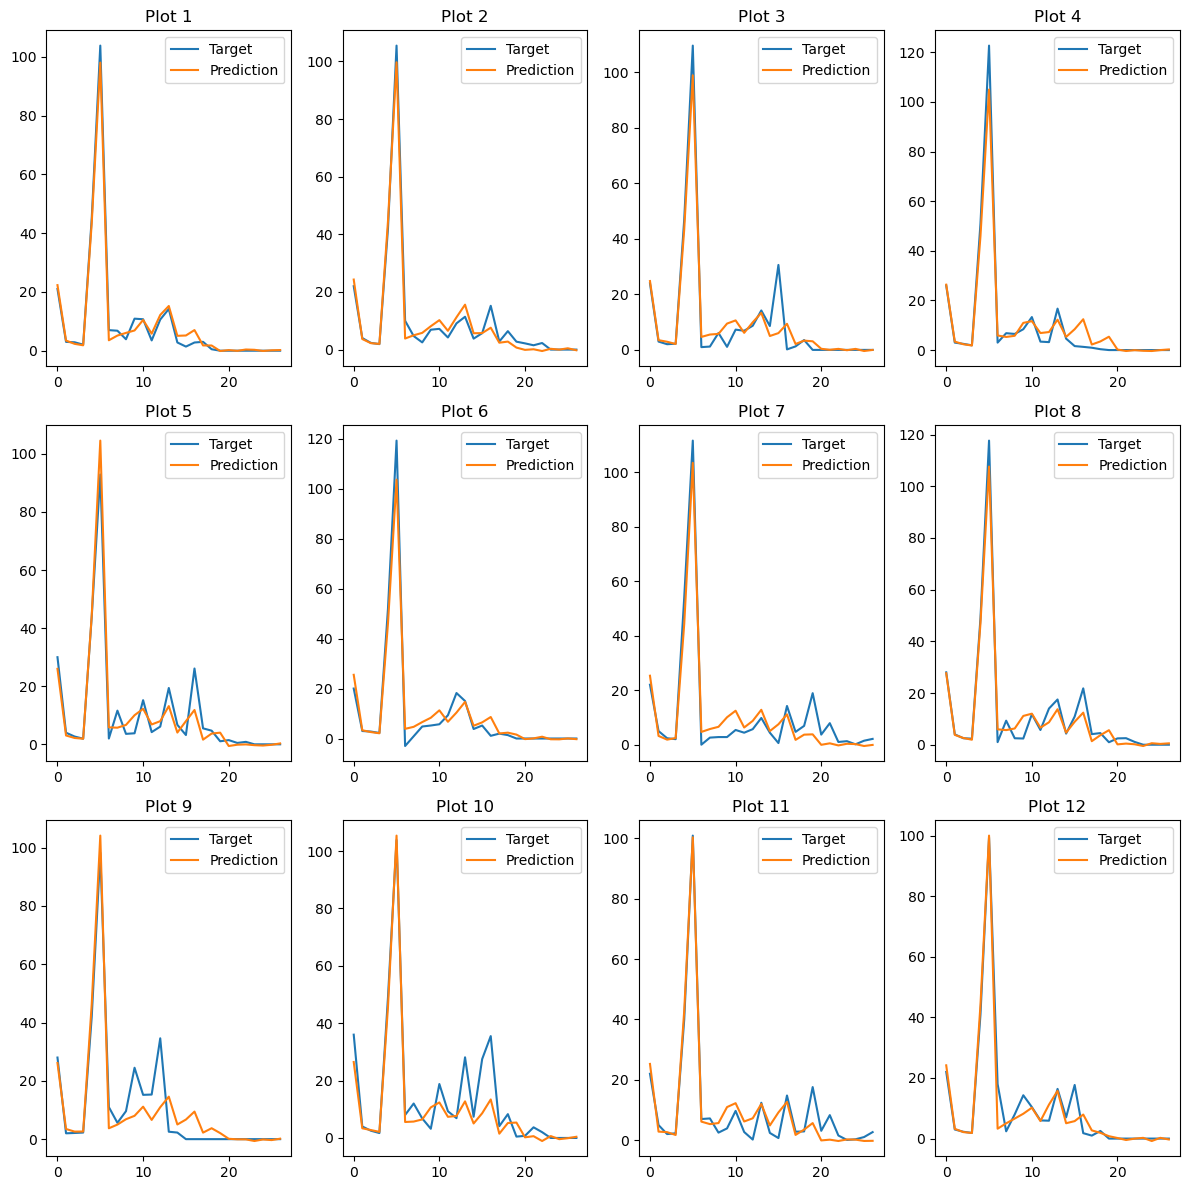

In [66]:
### 1st ROUND: CUSTOM LOSS, 6 EPOCHS ###
EPOCHS= 6 
LR = .0008
v_loss = criterion
optimizer = torch.optim.Adam(model6.parameters(), lr=LR)
train_loss1, val_loss1 = fit(model6, optimizer, v_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
show_samples(model6)


### 2nd round: MSELoss, 1 EPOCH ###
EPOCHS= 1 # 6
LR = .0008

base_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=LR)
train_loss2, val_loss2 = fit(model6, optimizer, base_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
show_samples(model6)

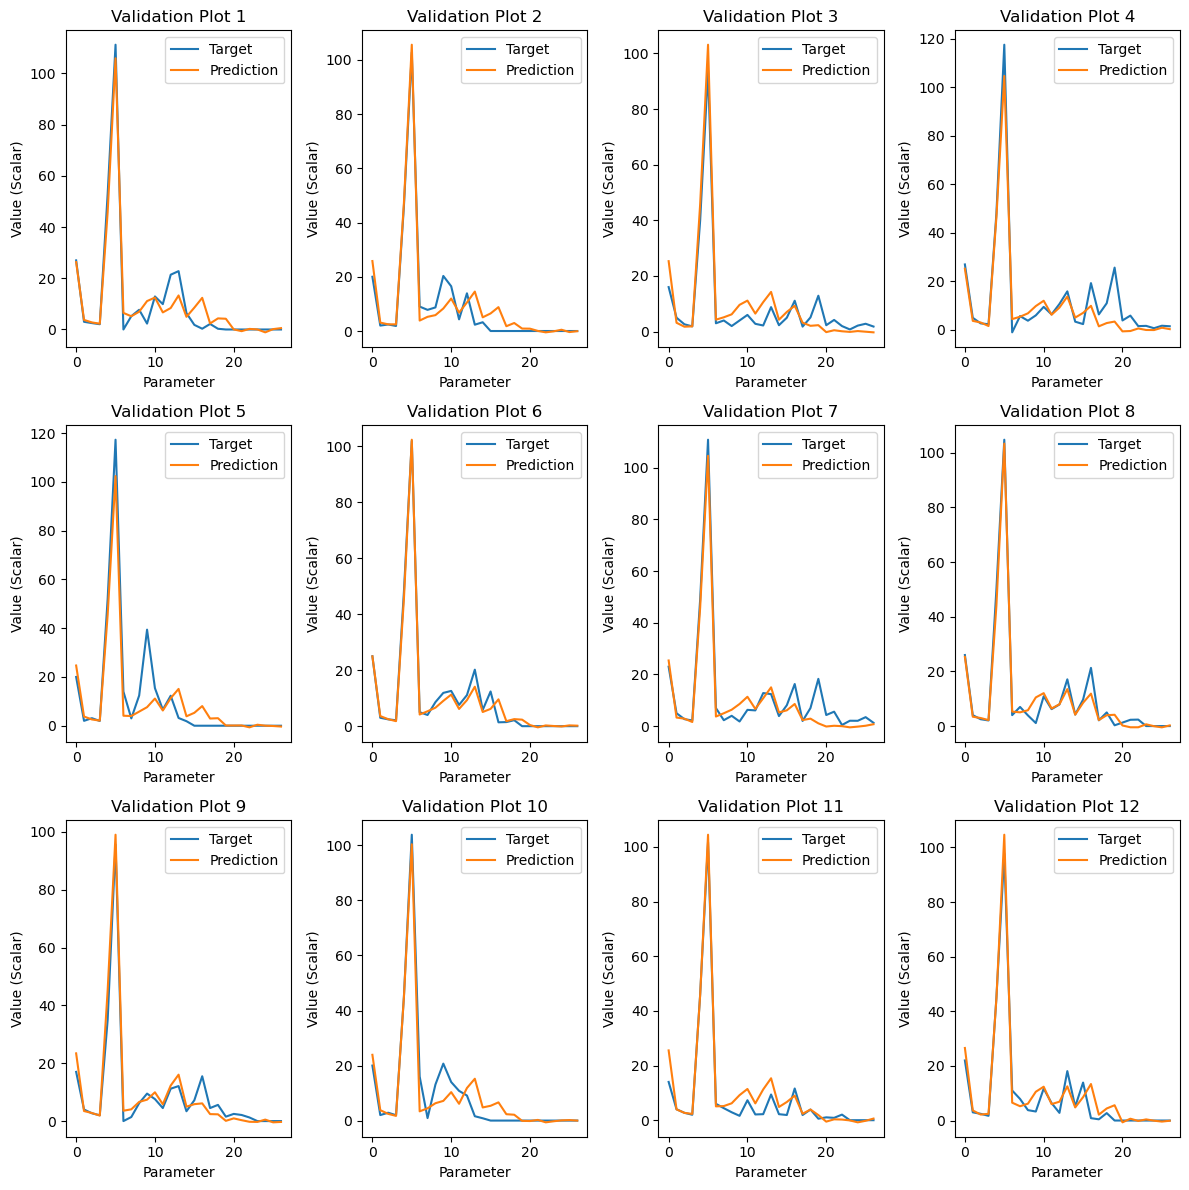

In [75]:
def show_samples(model):
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

    dl = DataLoader(data_val, batch_size=12, shuffle=True, num_workers=N_WORKERS)

    for x, y in dl:
        break

    for i, ax in enumerate(axs.flat):
        X = model(x.float())[i]
        X = X.detach().numpy()
        ax.plot(range(len(y[i])), y[i])
        
        ax.plot(range(len(X)), X)
        ax.legend(["Target", "Prediction"])
        ax.set_title(f"Validation Plot {i+1}")
        ax.set_xlabel("Parameter")
        ax.set_ylabel("Value (Scalar)")
    plt.tight_layout()
    plt.show()

show_samples(model6)

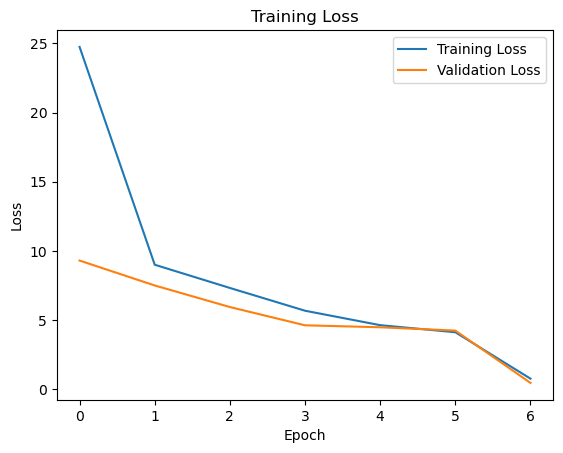

In [96]:
fig, ax = plt.subplots()
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(val_loss)), val_loss)
plt.title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])